In [1]:
#################################################################################################################################################
#
#                                          Set of tools for Analysis of XRD experimental data
#
##################################################################################################################################################
#################################################################################################################################################
#                                                            Loading of Packages
##################################################################################################################################################

import os
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize, signal

from lmfit import models

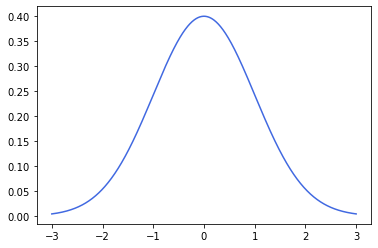

In [83]:
######################################################################################################################
#
#           Artificial generation of Gaussian Distribution function in the range from -3 to 3
#
######################################################################################################################

def g(x, A, μ, σ):
    return A / (σ * math.sqrt(2 * math.pi)) * np.exp(-(x-μ)**2 / (2*σ**2))

x = np.linspace(-3, 3, 1000)
fig, ax = plt.subplots()
ax.plot(x, g(x, 1, 0, 1), color  = 'royalblue')



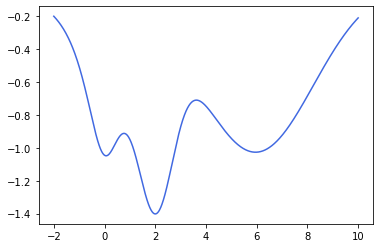

In [82]:
######################################################################################################################
#
#           Artificial generation of composed curves by adding two Distribution Functions
#
######################################################################################################################

def f(x):
    return np.exp(-(x-2)**2) + np.exp(-(x-6)**2/10) + 1/(x**2 + 1)

x = np.linspace(-2, 10, 1000)
fig, ax = plt.subplots()
ax.plot(x, -f(x), color = 'royalblue')



In [6]:


print('|{:>16}|{:>16}|{:>16}|'.format('initial','iterations','minimum'))
initial_guess = -0.5
result = optimize.minimize(lambda x: -f(x), [initial_guess])
print(f'|{initial_guess:+16.1f}|{result.nit:>16}|{result.x[0]:16.3f}|')

initial_guess = -2
result = optimize.minimize(lambda x: -f(x), [initial_guess])
print(f'|{initial_guess:+16.1f}|{result.nit:>16}|{result.x[0]:16.3f}|')

initial_guess = 9
result = optimize.minimize(lambda x: -f(x), [initial_guess])
print(f'|{initial_guess:+16.1f}|{result.nit:>16}|{result.x[0]:16.3f}|')



|         initial|      iterations|         minimum|
|            -0.5|               5|           0.064|
|            -2.0|               4|           2.001|
|            +9.0|               3|           5.955|


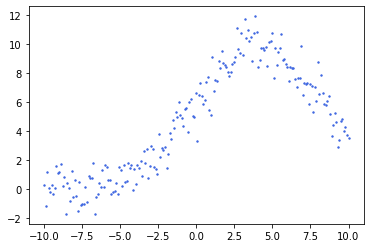

In [80]:
#####################################################################
#
#          Setting of the Distribution Function parameters
#
######################################################################

A = 100.0 # intensity
μ = 4.0  # mean
σ = 4.0 # peak width
n = 200
x = np.linspace(-10, 10, n)
y = g(x, A, μ, σ) + np.random.randn(n)

fig, ax = plt.subplots()
ax.scatter(x, y, s=2, color = 'royalblue')

In [8]:


def cost(parameters):
    a, b, c = parameters
    # y has been calculated in previous snippet
    return np.sum(np.power(g(x, a, b, c) - y, 2)) / len(x)

result = optimize.minimize(cost, [0, 0, 1])
print('steps', result.nit, result.fun)
print(f'amplitude: {result.x[0]:3.3f} mean: {result.x[1]:3.3f} sigma: {result.x[2]:3.3f}')



steps 15 0.9870450268464421
amplitude: 101.875 mean: 4.087 sigma: 4.070


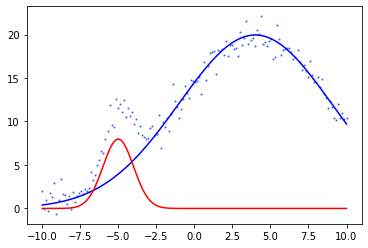

In [81]:
g_0 = [250.0, 4.0, 5.0]
g_1 = [20.0, -5.0, 1.0]
n = 150
x = np.linspace(-10, 10, n)
y = g(x, *g_0) + g(x, *g_1) + np.random.randn(n)

fig, ax = plt.subplots() # Setting plots together

ax.scatter(x, y, s=1, color = 'royalblue') # Scatter plots of the points to be 
ax.plot(x, g(x, *g_0), color = 'blue')
ax.plot(x, g(x, *g_1), color = 'red')

In [10]:


def cost(parameters):
    g_0 = parameters[:3]
    g_1 = parameters[3:6]
    return np.sum(np.power(g(x, *g_0) + g(x, *g_1) - y, 2)) / len(x)

initial_guess = [1, 0, 1, -1, 0, 1]
result = optimize.minimize(cost, initial_guess)
print('steps', result.nit, result.fun)
print(f'g_0: amplitude: {result.x[0]:3.3f} mean: {result.x[1]:3.3f} sigma: {result.x[2]:3.3f}')
print(f'g_1: amplitude: {result.x[3]:3.3f} mean: {result.x[4]:3.3f} sigma: {result.x[5]:3.3f}')



steps 67 0.7991578163106775
g_0: amplitude: 20.093 mean: -5.041 sigma: 0.942
g_1: amplitude: 249.327 mean: 4.022 sigma: 5.052


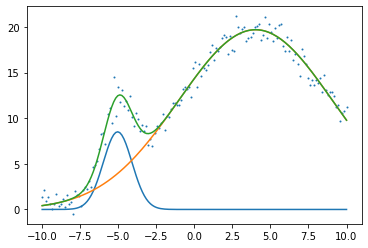

In [11]:
fig, ax = plt.subplots()
ax.scatter(x, y, s=1)
ax.plot(x, g(x, *result.x[:3]))
ax.plot(x, g(x, *result.x[3:6]))
ax.plot(x, g(x, *result.x[:3]) + g(x, *result.x[3:6]))

TypeError: cannot unpack non-iterable Figure object

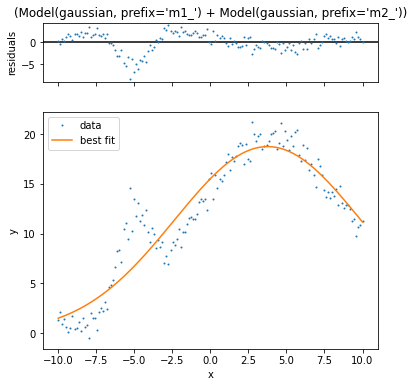

In [12]:
model_1 = models.GaussianModel(prefix='m1_')
model_2 = models.GaussianModel(prefix='m2_')
model = model_1 + model_2

params_1 = model_1.make_params(center=1, sigma=1)
params_2 = model_2.make_params(center=-1, sigma=1)
params = params_1.update(params_2)

output = model.fit(y, params, x=x)
fig, gridspec = output.plot(data_kws={'markersize': 1})

In [13]:


def generate_model(spec):
    composite_model = None
    params = None
    x = spec['x']
    y = spec['y']
    x_min = np.min(x)
    x_max = np.max(x)
    x_range = x_max - x_min
    y_max = np.max(y)
    for i, basis_func in enumerate(spec['model']):
        prefix = f'm{i}_'
        model = getattr(models, basis_func['type'])(prefix=prefix)
        if basis_func['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']: # for now VoigtModel has gamma constrained to sigma
            model.set_param_hint('sigma', min=1e-6, max=x_range)
            model.set_param_hint('center', min=x_min, max=x_max)
            model.set_param_hint('height', min=1e-6, max=1.1*y_max)
            model.set_param_hint('amplitude', min=1e-6)
            # default guess is horrible!! do not use guess()
            default_params = {
                prefix+'center': x_min + x_range * random.random(),
                prefix+'height': y_max * random.random(),
                prefix+'sigma': x_range * random.random()
            }
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
        if 'help' in basis_func:  # allow override of settings in parameter
            for param, options in basis_func['help'].items():
                model.set_param_hint(param, **options)
        model_params = model.make_params(**default_params, **basis_func.get('params', {}))
        if params is None:
            params = model_params
        else:
            params.update(model_params)
        if composite_model is None:
            composite_model = model
        else:
            composite_model = composite_model + model
    return composite_model, params



TypeError: cannot unpack non-iterable Figure object

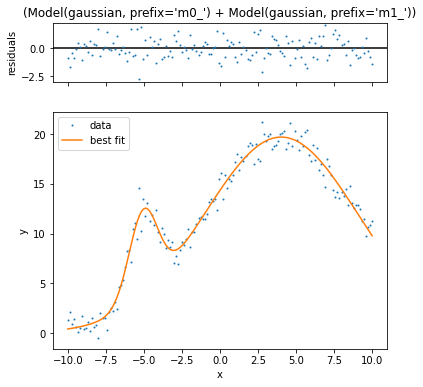

In [14]:


spec = {
    'x': x,
    'y': y,
    'model': [
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'}
    ]
}

model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig, gridspec = output.plot(data_kws={'markersize': 1})
plot_to_blog(fig, 'xrd-fitting-two-gaussian-noise-lmfit-spec.png')



In [15]:


def update_spec_from_peaks(spec, model_indicies, peak_widths=(10, 25), **kwargs):
    x = spec['x']
    y = spec['y']
    x_range = np.max(x) - np.min(x)
    peak_indicies = signal.find_peaks_cwt(y, peak_widths)
    np.random.shuffle(peak_indicies)
    for peak_indicie, model_indicie in zip(peak_indicies.tolist(), model_indicies):
        model = spec['model'][model_indicie]
        if model['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']:
            params = {
                'height': y[peak_indicie],
                'sigma': x_range / len(x) * np.min(peak_widths),
                'center': x[peak_indicie]
            }
            if 'params' in model:
                model.update(params)
            else:
                model['params'] = params
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
    return peak_indicies



In [16]:
spec = {
    'x': df.index.values,
    'y': df['count'].values,
    'model': [
        {'type': 'VoigtModel'},
        {'type': 'VoigtModel'},
        {'type': 'VoigtModel'},
        {'type': 'VoigtModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
    ]
}

peaks_found = update_spec_from_peaks(spec, [0, 1, 2, 3, 4, 5, 6], peak_widths=(15,))
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
for i in peaks_found:
    ax.axvline(x=spec['x'][i], c='black', linestyle='dotted')


NameError: name 'df' is not defined

TypeError: cannot unpack non-iterable Figure object

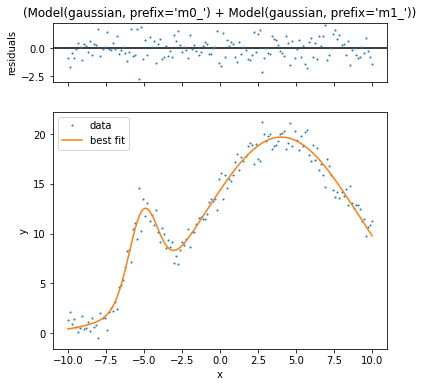

In [17]:
model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig, gridspec = output.plot(data_kws={'markersize':  1})

2


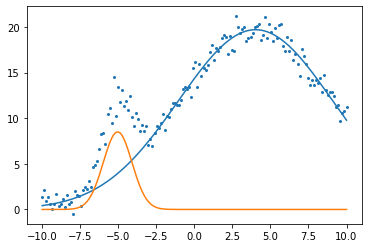

In [19]:
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
components = output.eval_components(x=spec['x'])
print(len(spec['model']))
for i, model in enumerate(spec['model']):
    ax.plot(spec['x'], components[f'm{i}_'])

In [20]:
spec = {
    'x': df.index.values,
    'y': df['count'].values,
    'model': [
        {
            'type': 'GaussianModel',
            'params': {'center': 34.11, 'height': 13.08, 'sigma': 0.1},
            'help': {'center': {'min': 33.5, 'max': 34.5}}
        },
        {
            'type': 'VoigtModel',
            'params': {'center': 36.37, 'height': 30.94, 'sigma': 0.1, 'gamma': 0.1},
            'help': {'center': {'min': 35, 'max': 37}}
        },
        {'type': 'GaussianModel', 'params': {'center': 39.57, 'height': 76.56, 'sigma': 0.1}},
        {
            'type': 'GaussianModel',
            'params': {'center': 40.85, 'height': 30.77, 'sigma': 0.1},
            'help': {'center': {'min': 40, 'max': 42}}
        },
        {'type': 'VoigtModel', 'params': {'center': 41.73, 'height': 38.44, 'sigma': 0.05, 'gamma': 0.15}},
        {
            'type': 'GaussianModel',
            'params': {'center': 42.55, 'height': 45.29, 'sigma': 0.1},
            'help': {'center': {'min': 42, 'max': 43}}
        },
        {'type': 'GaussianModel', 'help': {'center': {'max': 39.2}}},
        #{'type': 'GaussianModel'},
        #{'type': 'GaussianModel'}
    ]
}

model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig, gridspec = output.plot(data_kws={'markersize': 1})

NameError: name 'df' is not defined

2


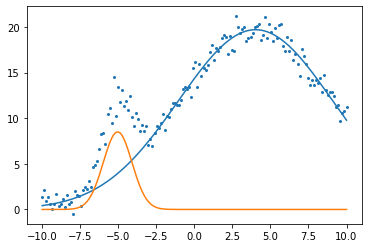

In [21]:
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
components = output.eval_components(x=spec['x'])
print(len(spec['model']))
for i, model in enumerate(spec['model']):
    ax.plot(spec['x'], components[f'm{i}_'])

In [23]:


def print_best_values(spec, output):
    model_params = {
        'GaussianModel':   ['amplitude', 'sigma'],
        'LorentzianModel': ['amplitude', 'sigma'],
        'VoigtModel':      ['amplitude', 'sigma', 'gamma']
    }
    best_values = output.best_values
    print('center    model   amplitude     sigma      gamma')
    for i, model in enumerate(spec['model']):
        prefix = f'm{i}_'
        values = ', '.join(f'{best_values[prefix+param]:8.3f}' for param in model_params[model["type"]])
        print(f'[{best_values[prefix+"center"]:3.3f}] {model["type"]:16}: {values}')



In [26]:
image_dir = "C:/Users/renea/Desktop"

def plot_to_blog(fig, figure_name):
    filename = os.path.expanduser(f'{image_dir}/{figure_name}')
    fig.savefig(filename)
    return filename

'C:/Users/renea/Desktop/xrd-fitting-gaussian.png'

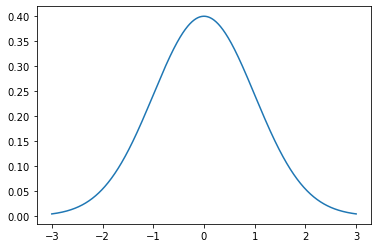

In [27]:


def g(x, A, μ, σ):
    return A / (σ * math.sqrt(2 * math.pi)) * np.exp(-(x-μ)**2 / (2*σ**2))

x = np.linspace(-3, 3, 1000)
fig, ax = plt.subplots()
ax.plot(x, g(x, 1, 0, 1))
plot_to_blog(fig, 'xrd-fitting-gaussian.png')

